In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.transforms as mtransforms
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
import scipy
import scipy.stats as st 
from matplotlib import patches
import matplotlib.colors as mcolors

In [2]:
data_df = pd.read_csv("../results/simulation_results.csv", index_col=0)
print(data_df.shape)
data_df["method"] = pd.Categorical(data_df['method'], ["aldex", "ancombc2", "linda", "maaslin3",
                                                       "NBZIMM", "lmerseq", "maaslin2", "aldex_lin"])
data_df = data_df.loc[~data_df["method"].isin(["aldex_lin", "maaslin2"]),]
print(data_df)

(660, 9)
     n_s    method  system  pc_l  pc_u  lfc_l  lfc_u  FDR_mean  Power_mean
1     12    NBZIMM  armpit   0.0   0.5    0.0    3.0  0.457500    0.058660
2     12    NBZIMM     gut   0.0   0.2    0.0    3.0  0.441575    0.127177
3     12    NBZIMM     gut   0.1   0.7   -2.0    3.0  0.270249    0.110342
4     12    NBZIMM     gut   0.2   0.2   -2.5    2.5  0.104115    0.148667
5     12    NBZIMM    oral   0.0   0.2    0.0    3.0  0.538582    0.074540
..   ...       ...     ...   ...   ...    ...    ...       ...         ...
656   80  maaslin3     gut   0.2   0.2   -2.5    2.5  0.030891    0.557958
657   80  maaslin3    oral   0.0   0.2    0.0    3.0  0.148892    0.712471
658   80  maaslin3    oral   0.1   0.4   -2.0    3.0  0.098067    0.597351
659   80  maaslin3    oral   0.1   0.7   -2.0    3.0  0.216021    0.540211
660   80  maaslin3    oral   0.2   0.2   -2.5    2.5  0.040295    0.584713

[484 rows x 9 columns]


/tmp/ipykernel_186763/288668099.py:63: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/288668099.py:63: UserWarning: The dashes list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/288668099.py:82: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/288668099.py:82: UserWarning: The dashes list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/288668099.py:63: UserWarning: The palette list has more values (6) than needed (1), which may not be

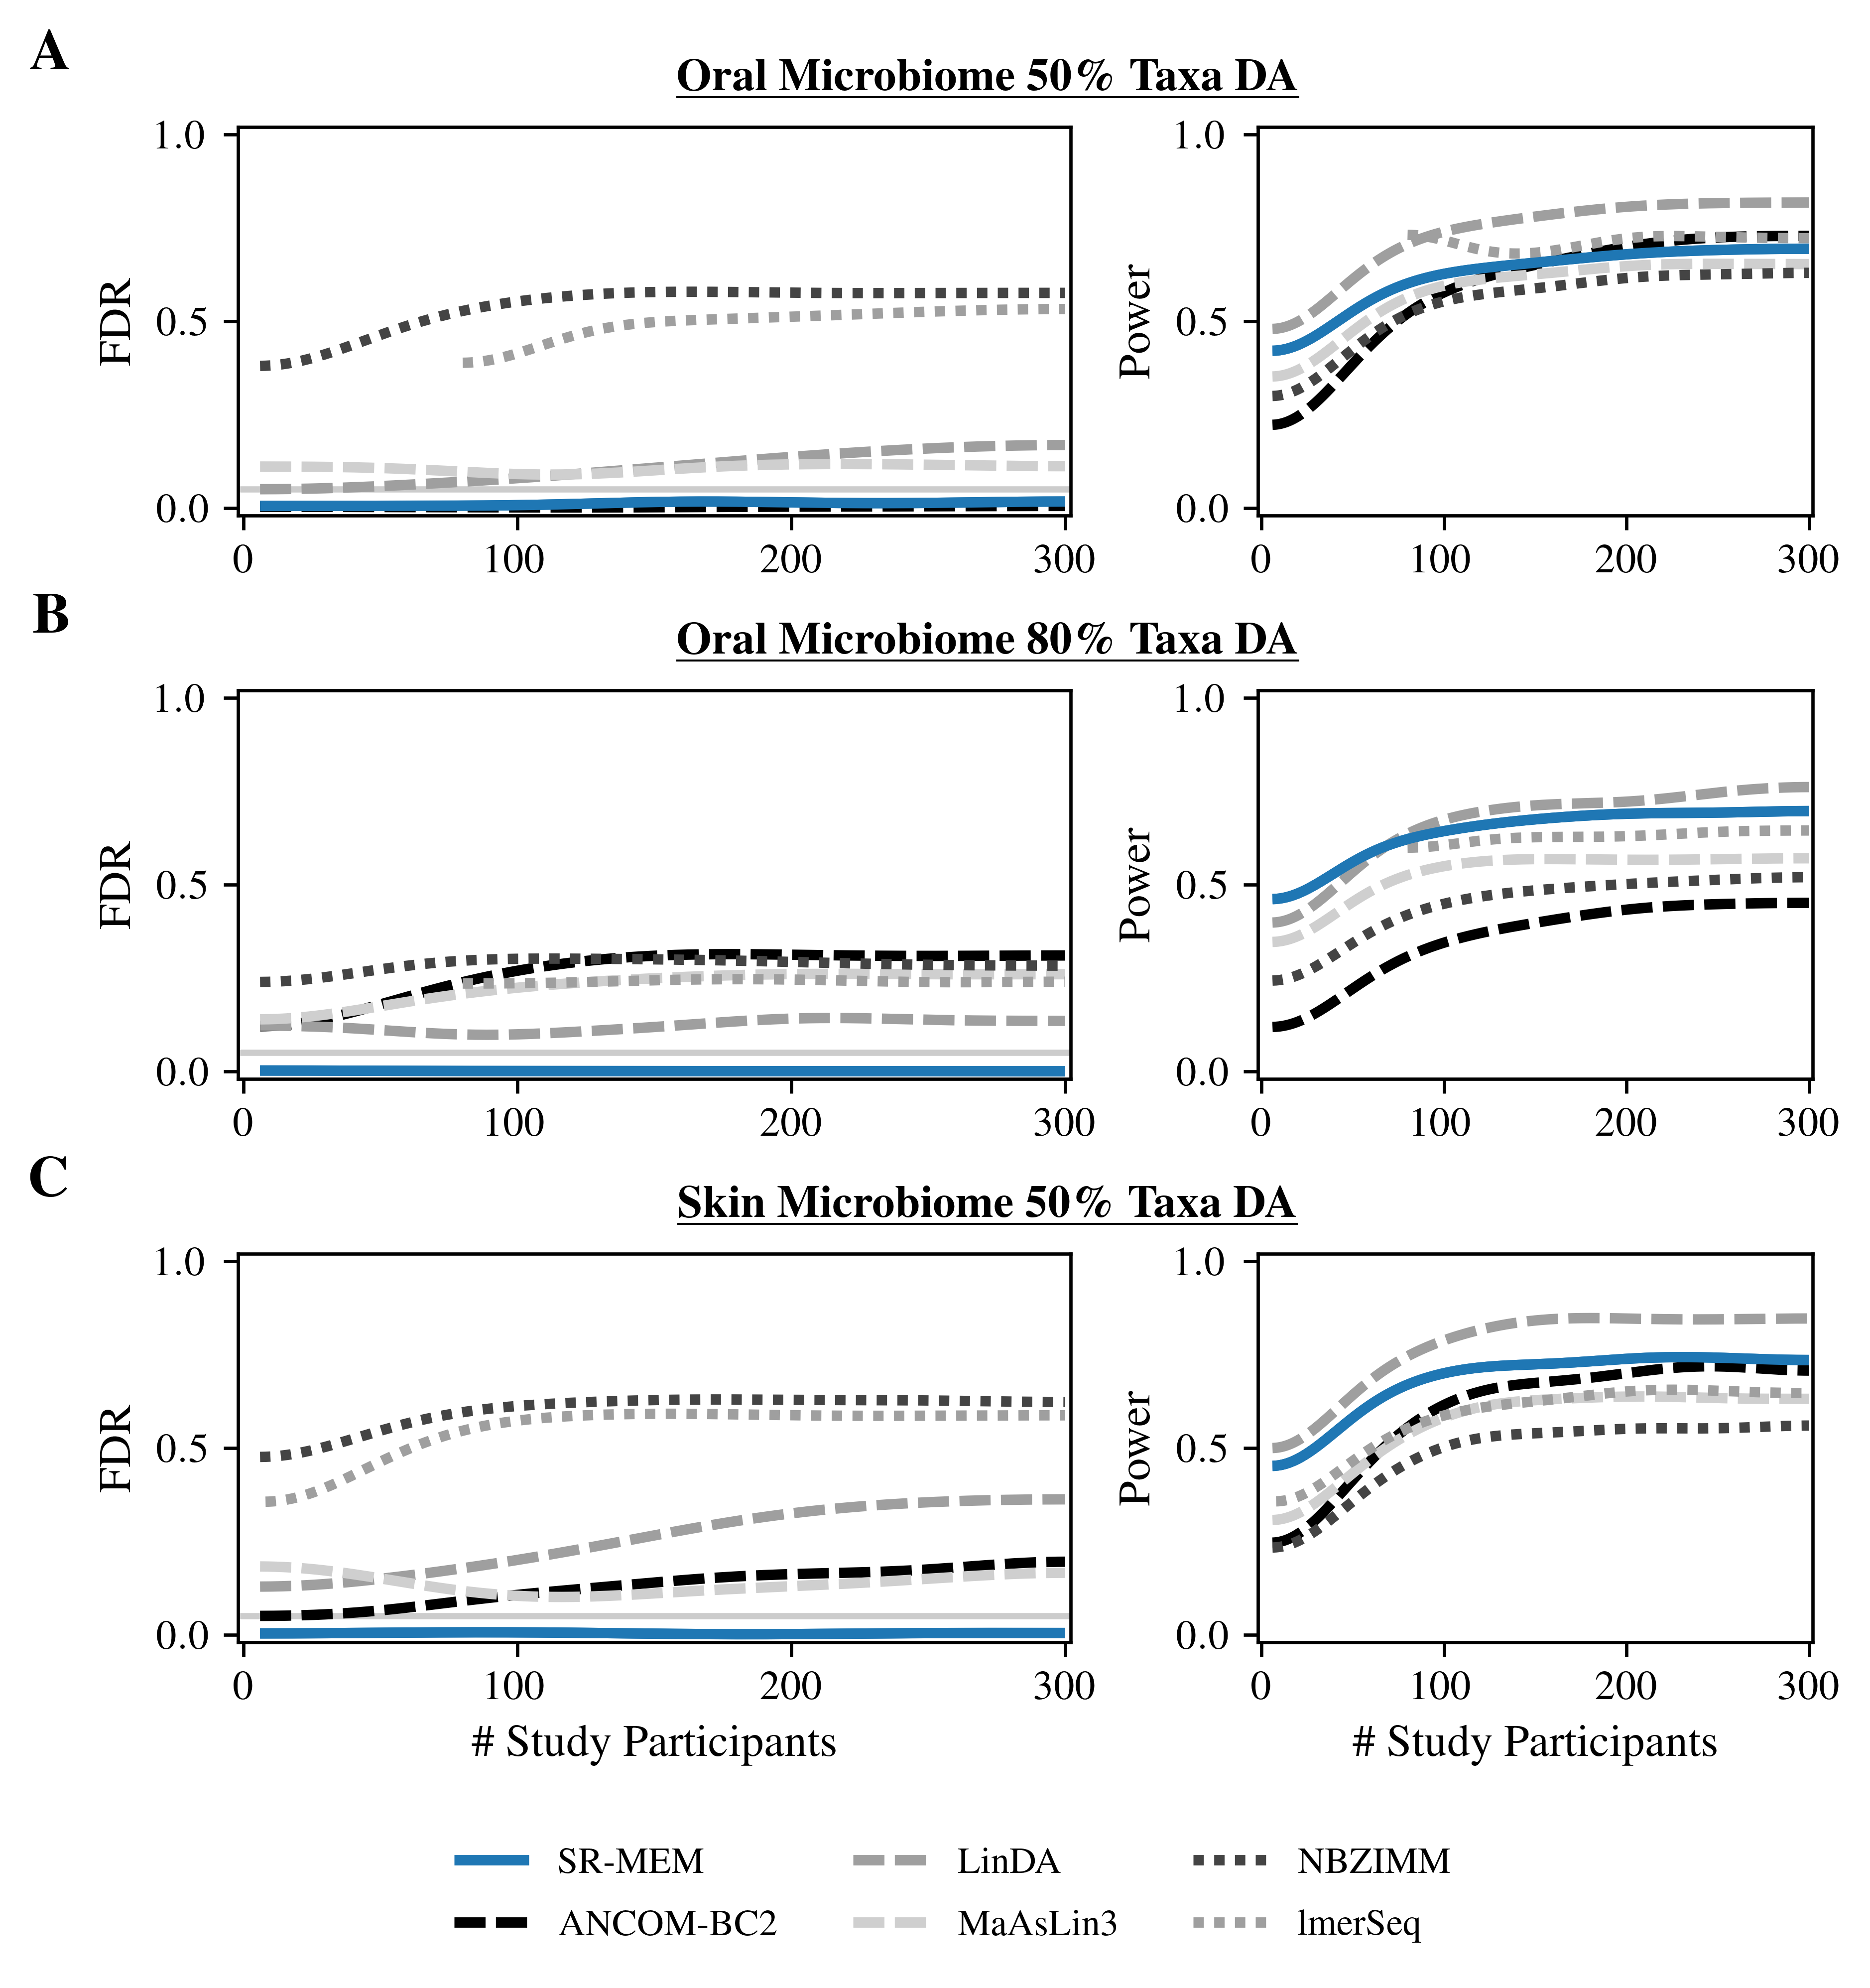

In [3]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["text.usetex"] = True

gs_kw = dict(width_ratios=[1.5,1],
             height_ratios=[1,1,1])

width = 6.8
height = 6.5
dpi = 600
pw = width*dpi
ph = height*dpi
palette = ['#1f77b4', '#000000', '#9F9F9F', '#CFCFCF', '#444444',  '#9F9F9F']
dashes = [(1,0), (3,1), (3,1), (3,1), (1,1), (1,1)]

fig, axs = plt.subplot_mosaic([["A", "B"],
                               ["C", "D"],
                               ["E", "F"]], figsize=(pw/dpi, ph/dpi),
                              dpi=dpi, gridspec_kw=gs_kw)

def smooth_it(df_s, col, sigma=30):
    pdf = pd.DataFrame()
    for method in df_s["method"].unique():
        sdf = df_s[df_s["method"]==method]
        n_s = np.linspace(sdf["n_s"].min(), sdf["n_s"].max(), 300) 
        spl = make_interp_spline(sdf["n_s"], sdf[col], k=1)
        smoothed = gaussian_filter1d(spl(n_s), sigma=sigma)
        if col == "FDR_mean":
            name = "FDR_mean"
        else:
            name = "Power_mean"
        if pdf.empty:
            pdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
        else:
            tdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
            pdf = pd.concat([pdf, tdf])
    return(pdf)

ylim_l = -0.02
ylim_u = 1.02

counter = 0
axis_list = ["A", "B", "C", "D", "E", "F"]
sets = [["oral", 0.1, 0.4],
        ["oral", 0.1, 0.7],
        ["armpit", 0.0, 0.5]]
titles = ["Oral Microbiome 50\\% Taxa DA",
          "Oral Microbiome 80\\% Taxa DA",
          "Skin Microbiome 50\\% Taxa DA"]
for index, curr_set in enumerate(sets):
    g_df = data_df.loc[
        (data_df["system"]==curr_set[0])&(data_df["pc_l"]==curr_set[1])&(data_df["pc_u"]==curr_set[2])]
    g_df = g_df.sort_values(by=["method", "n_s"])
    
    ax_l = axis_list[counter]
    ax_r = axis_list[counter+1]

    pdf = smooth_it(g_df, "FDR_mean")
    axs[ax_l].set_xlim(-2, 302)
    axs[ax_l].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="FDR_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    if curr_set!=["oral", 0.1, 0.41]:
        sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
                     style="method", palette=palette, ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    axs[ax_l].axhline(y=0.05, linestyle="solid", linewidth=1.5, color="gray", zorder=-5, alpha=0.4)
    axs[ax_l].get_legend().remove()
    if index==2:
        axs[ax_l].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_l].set_xlabel(None)
    axs[ax_l].set_ylabel("FDR", fontsize=11)
    axs[ax_l].text(0.9, 1.07, r"\underline{{\textbf{{{}}}}}".format(titles[index]), 
                   fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    #axs[ax_l].text(0.9, 1.07, r"\underline{\textbf{}}".format(titles[index]), 
    #               fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    
    pdf = smooth_it(g_df, "Power_mean")
    axs[ax_r].set_xlim(-2, 302)
    axs[ax_r].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="Power_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
                 style="method", palette=palette, ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    axs[ax_r].get_legend().remove()
    if index==2:
        axs[ax_r].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_r].set_xlabel(None)
    axs[ax_r].set_ylabel("Power", fontsize=11)
    
    counter += 2

axs["A"].text(-0.2, 1.25, r"\textbf{A}", transform=axs["A"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')
axs["C"].text(-0.2, 1.25, r"\textbf{B}", transform=axs["C"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')
axs["E"].text(-0.2, 1.25, r"\textbf{C}", transform=axs["E"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(bottom=0.1, wspace=0.27, hspace=0.45)
handles, labels = axs["F"].get_legend_handles_labels()
label_dict = {"aldex": "SR-MEM", "ancombc2": "ANCOM-BC2",
              "linda": "LinDA", "lmerseq": "lmerSeq", "maaslin3": "MaAsLin3",
              "NBZIMM": "NBZIMM"}
labels = [label_dict[l] for l in labels]
leg = axs["F"].legend(handles=handles[0:6], labels=labels[0:6], ncol=3, loc='upper center', 
                      bbox_to_anchor=(-0.55, -0.44), fancybox=False, shadow=False,
                      fontsize=9, frameon=False, labelspacing=0.75)
fig.savefig('../../../figures/Figure_1.png', bbox_inches='tight')

/tmp/ipykernel_186763/3393440239.py:60: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/3393440239.py:60: UserWarning: The dashes list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/3393440239.py:79: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/3393440239.py:79: UserWarning: The dashes list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/3393440239.py:60: UserWarning: The palette list has more values (6) than needed (1), which may n

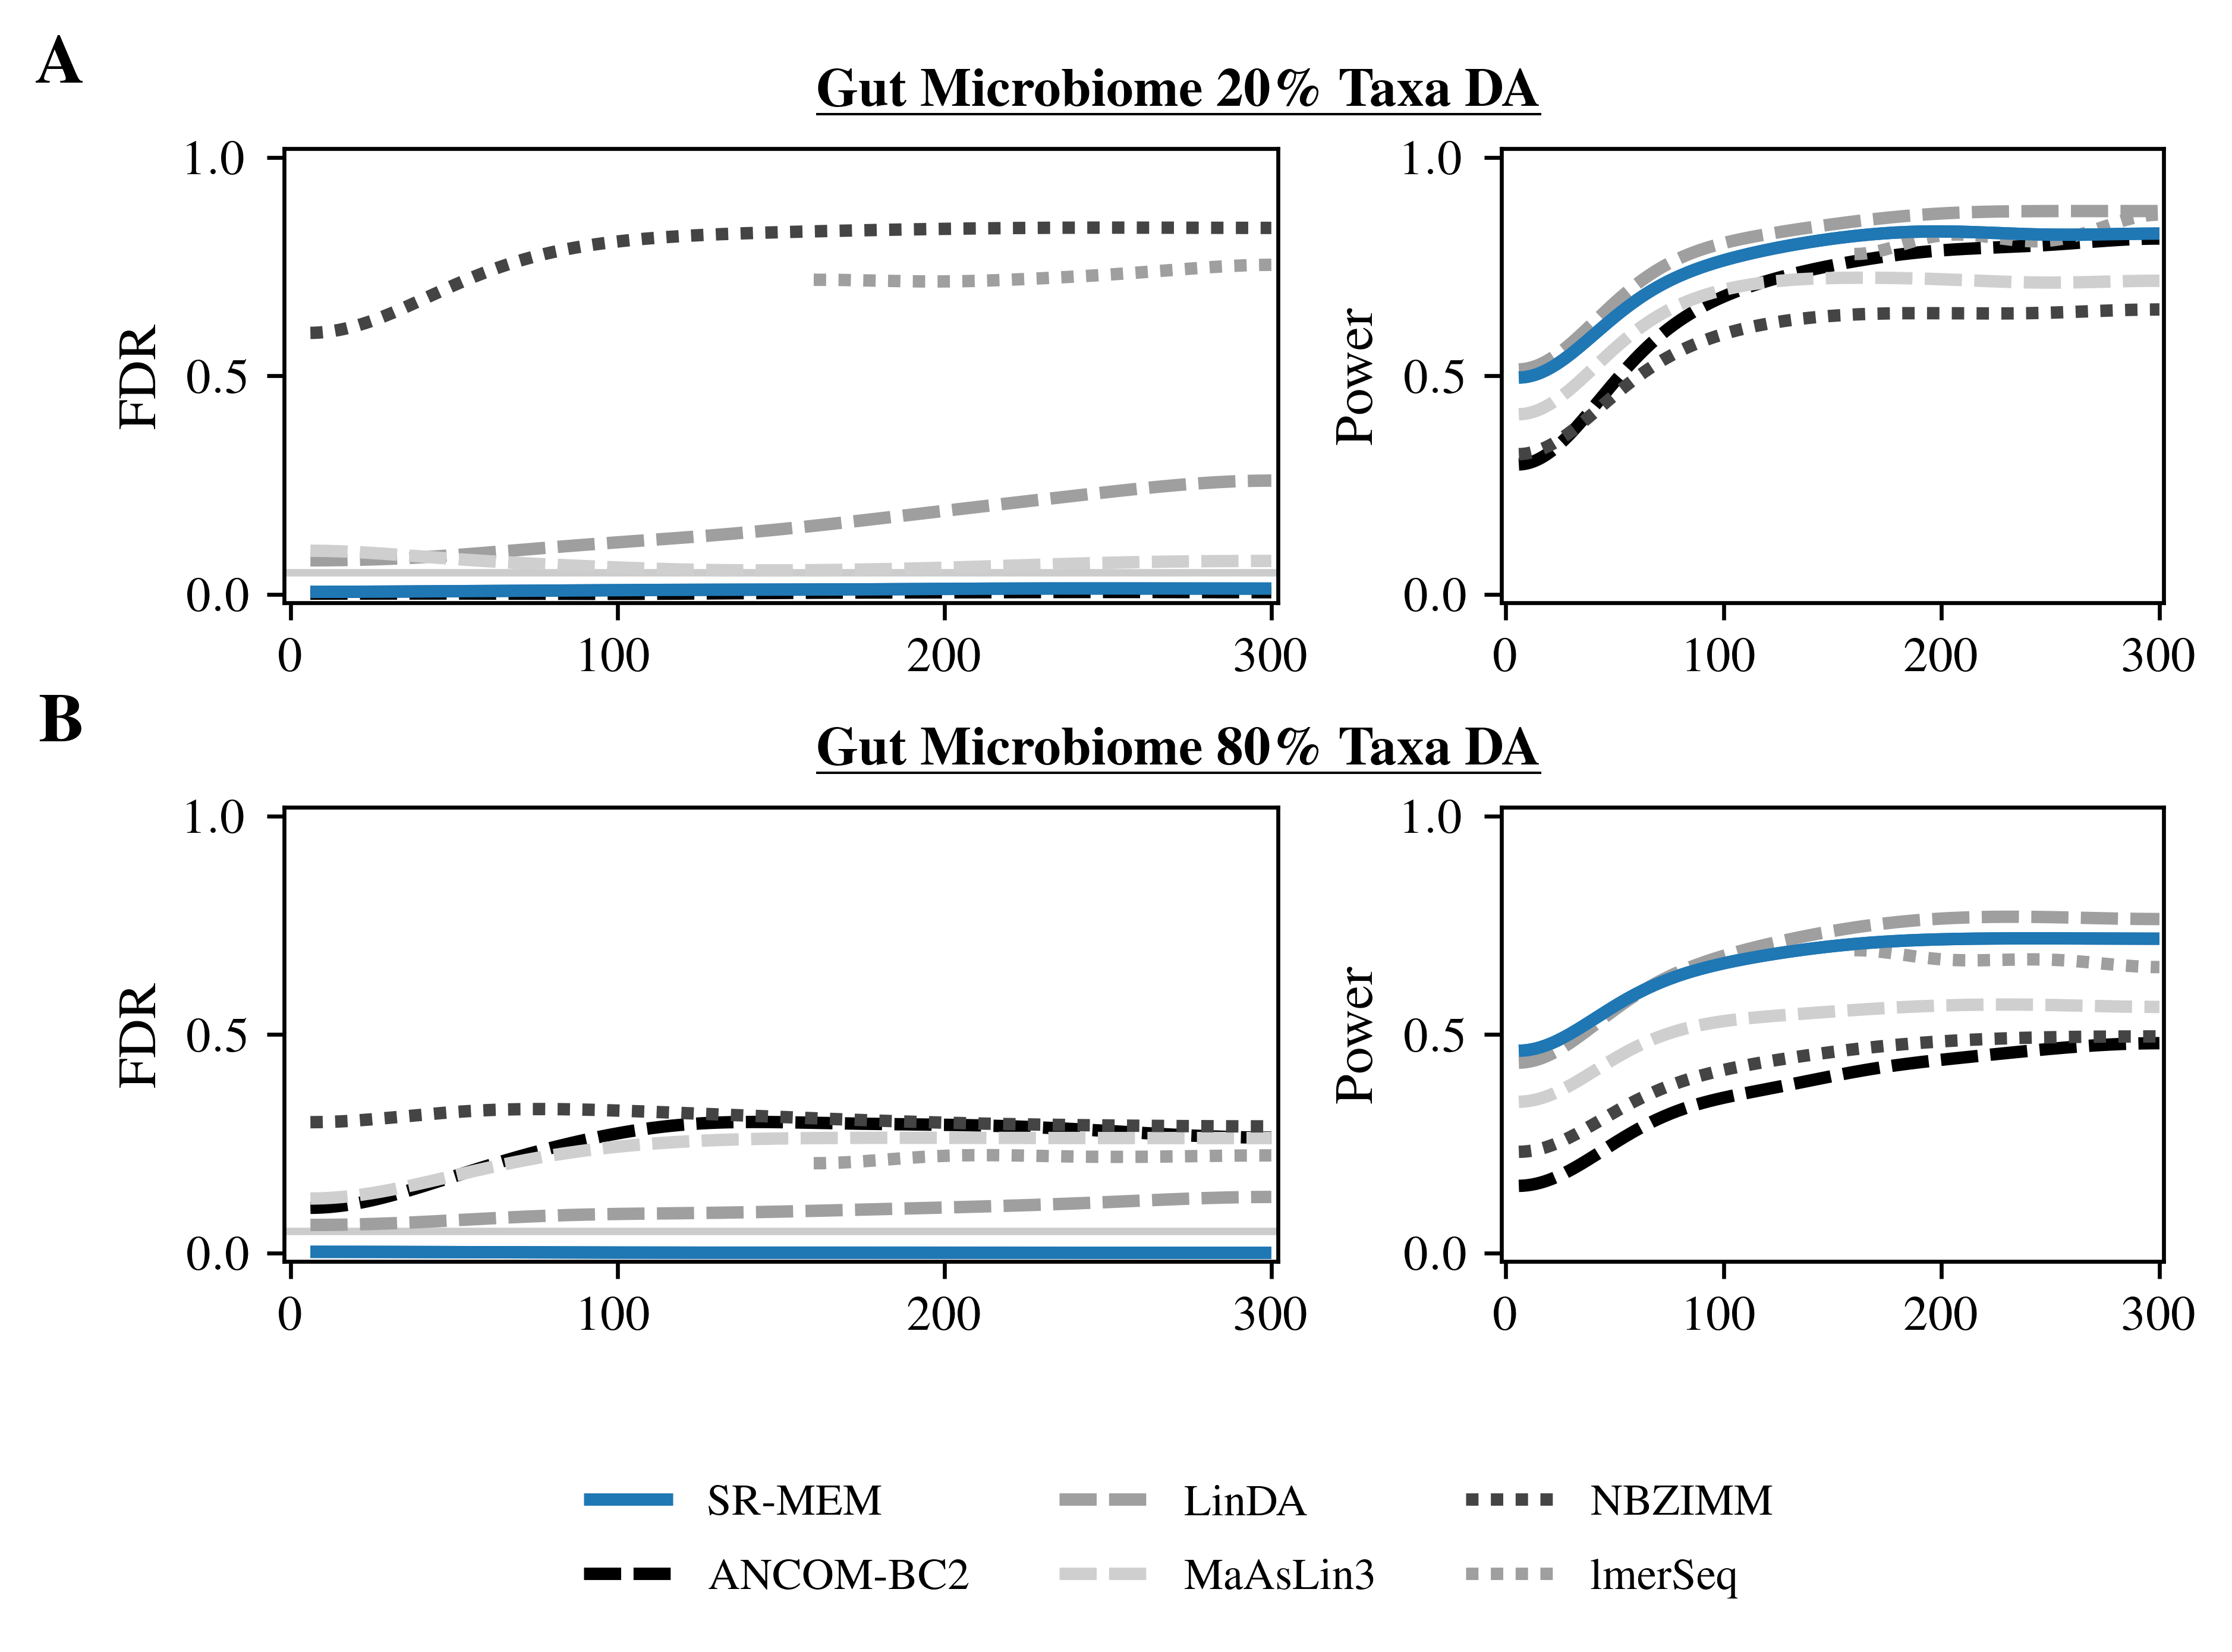

In [4]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["text.usetex"] = True

gs_kw = dict(width_ratios=[1.5,1],
             height_ratios=[1,1])

width = 6.8
height = 4
dpi = 600
pw = width*dpi
ph = height*dpi
palette = ['#1f77b4', '#000000', '#9F9F9F', '#CFCFCF', '#444444',  '#9F9F9F']
dashes = [(1,0), (3,1), (3,1), (3,1), (1,1), (1,1)]

fig, axs = plt.subplot_mosaic([["A", "B"],
                               ["C", "D"]], figsize=(pw/dpi, ph/dpi),
                              dpi=dpi, gridspec_kw=gs_kw)

def smooth_it(df_s, col, sigma=30):
    pdf = pd.DataFrame()
    for method in df_s["method"].unique():
        sdf = df_s[df_s["method"]==method]
        n_s = np.linspace(sdf["n_s"].min(), sdf["n_s"].max(), 300) 
        spl = make_interp_spline(sdf["n_s"], sdf[col], k=1)
        smoothed = gaussian_filter1d(spl(n_s), sigma=sigma)
        if col == "FDR_mean":
            name = "FDR_mean"
        else:
            name = "Power_mean"
        if pdf.empty:
            pdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
        else:
            tdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
            pdf = pd.concat([pdf, tdf])
    return(pdf)

ylim_l = -0.02
ylim_u = 1.02

counter = 0
axis_list = ["A", "B", "C", "D"]
sets = [["gut", 0, 0.2],
        ["gut", 0.1, 0.7]]
titles = ["Gut Microbiome 20\\% Taxa DA",
          "Gut Microbiome 80\\% Taxa DA"]
for index, curr_set in enumerate(sets):
    g_df = data_df.loc[
        (data_df["system"]==curr_set[0])&(data_df["pc_l"]==curr_set[1])&(data_df["pc_u"]==curr_set[2])]
    g_df = g_df.sort_values(by=["method", "n_s"])
    
    ax_l = axis_list[counter]
    ax_r = axis_list[counter+1]

    pdf = smooth_it(g_df, "FDR_mean")
    axs[ax_l].set_xlim(-2, 302)
    axs[ax_l].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="FDR_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    if curr_set!=["oral", 0.1, 0.41]:
        sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
                     style="method", palette=palette, ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    axs[ax_l].axhline(y=0.05, linestyle="solid", linewidth=1.5, color="gray", zorder=-5, alpha=0.4)
    axs[ax_l].get_legend().remove()
    if index==2:
        axs[ax_l].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_l].set_xlabel(None)
    axs[ax_l].set_ylabel("FDR", fontsize=11)
    axs[ax_l].text(0.9, 1.07, r"\underline{{\textbf{{{}}}}}".format(titles[index]), 
                   fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    #axs[ax_l].text(0.9, 1.07, r"\underline{\textbf{}}".format(titles[index]), 
    #               fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    
    pdf = smooth_it(g_df, "Power_mean")
    axs[ax_r].set_xlim(-2, 302)
    axs[ax_r].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="Power_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
                 style="method", palette=palette, ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    axs[ax_r].get_legend().remove()
    if index==2:
        axs[ax_r].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_r].set_xlabel(None)
    axs[ax_r].set_ylabel("Power", fontsize=11)
    
    counter += 2

axs["A"].text(-0.2, 1.25, r"\textbf{A}", transform=axs["A"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')
axs["C"].text(-0.2, 1.25, r"\textbf{B}", transform=axs["C"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(bottom=0.1, wspace=0.27, hspace=0.45)
handles, labels = axs["C"].get_legend_handles_labels()
label_dict = {"aldex": "SR-MEM", "ancombc2": "ANCOM-BC2",
              "linda": "LinDA", "lmerseq": "lmerSeq", "maaslin3": "MaAsLin3",
              "NBZIMM": "NBZIMM"}
labels = [label_dict[l] for l in labels]
leg = axs["C"].legend(handles=handles[0:6], labels=labels[0:6], ncol=3, loc='upper center', 
                      bbox_to_anchor=(0.9, -0.4), fancybox=False, shadow=False,
                      fontsize=9, frameon=False, labelspacing=0.75)
fig.savefig('../../../supplement/SFigure_2.png', bbox_inches='tight')

/tmp/ipykernel_186763/674597280.py:60: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/674597280.py:60: UserWarning: The dashes list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/674597280.py:79: UserWarning: The palette list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/674597280.py:79: UserWarning: The dashes list has more values (6) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/674597280.py:60: UserWarning: The palette list has more values (6) than needed (1), which may not be

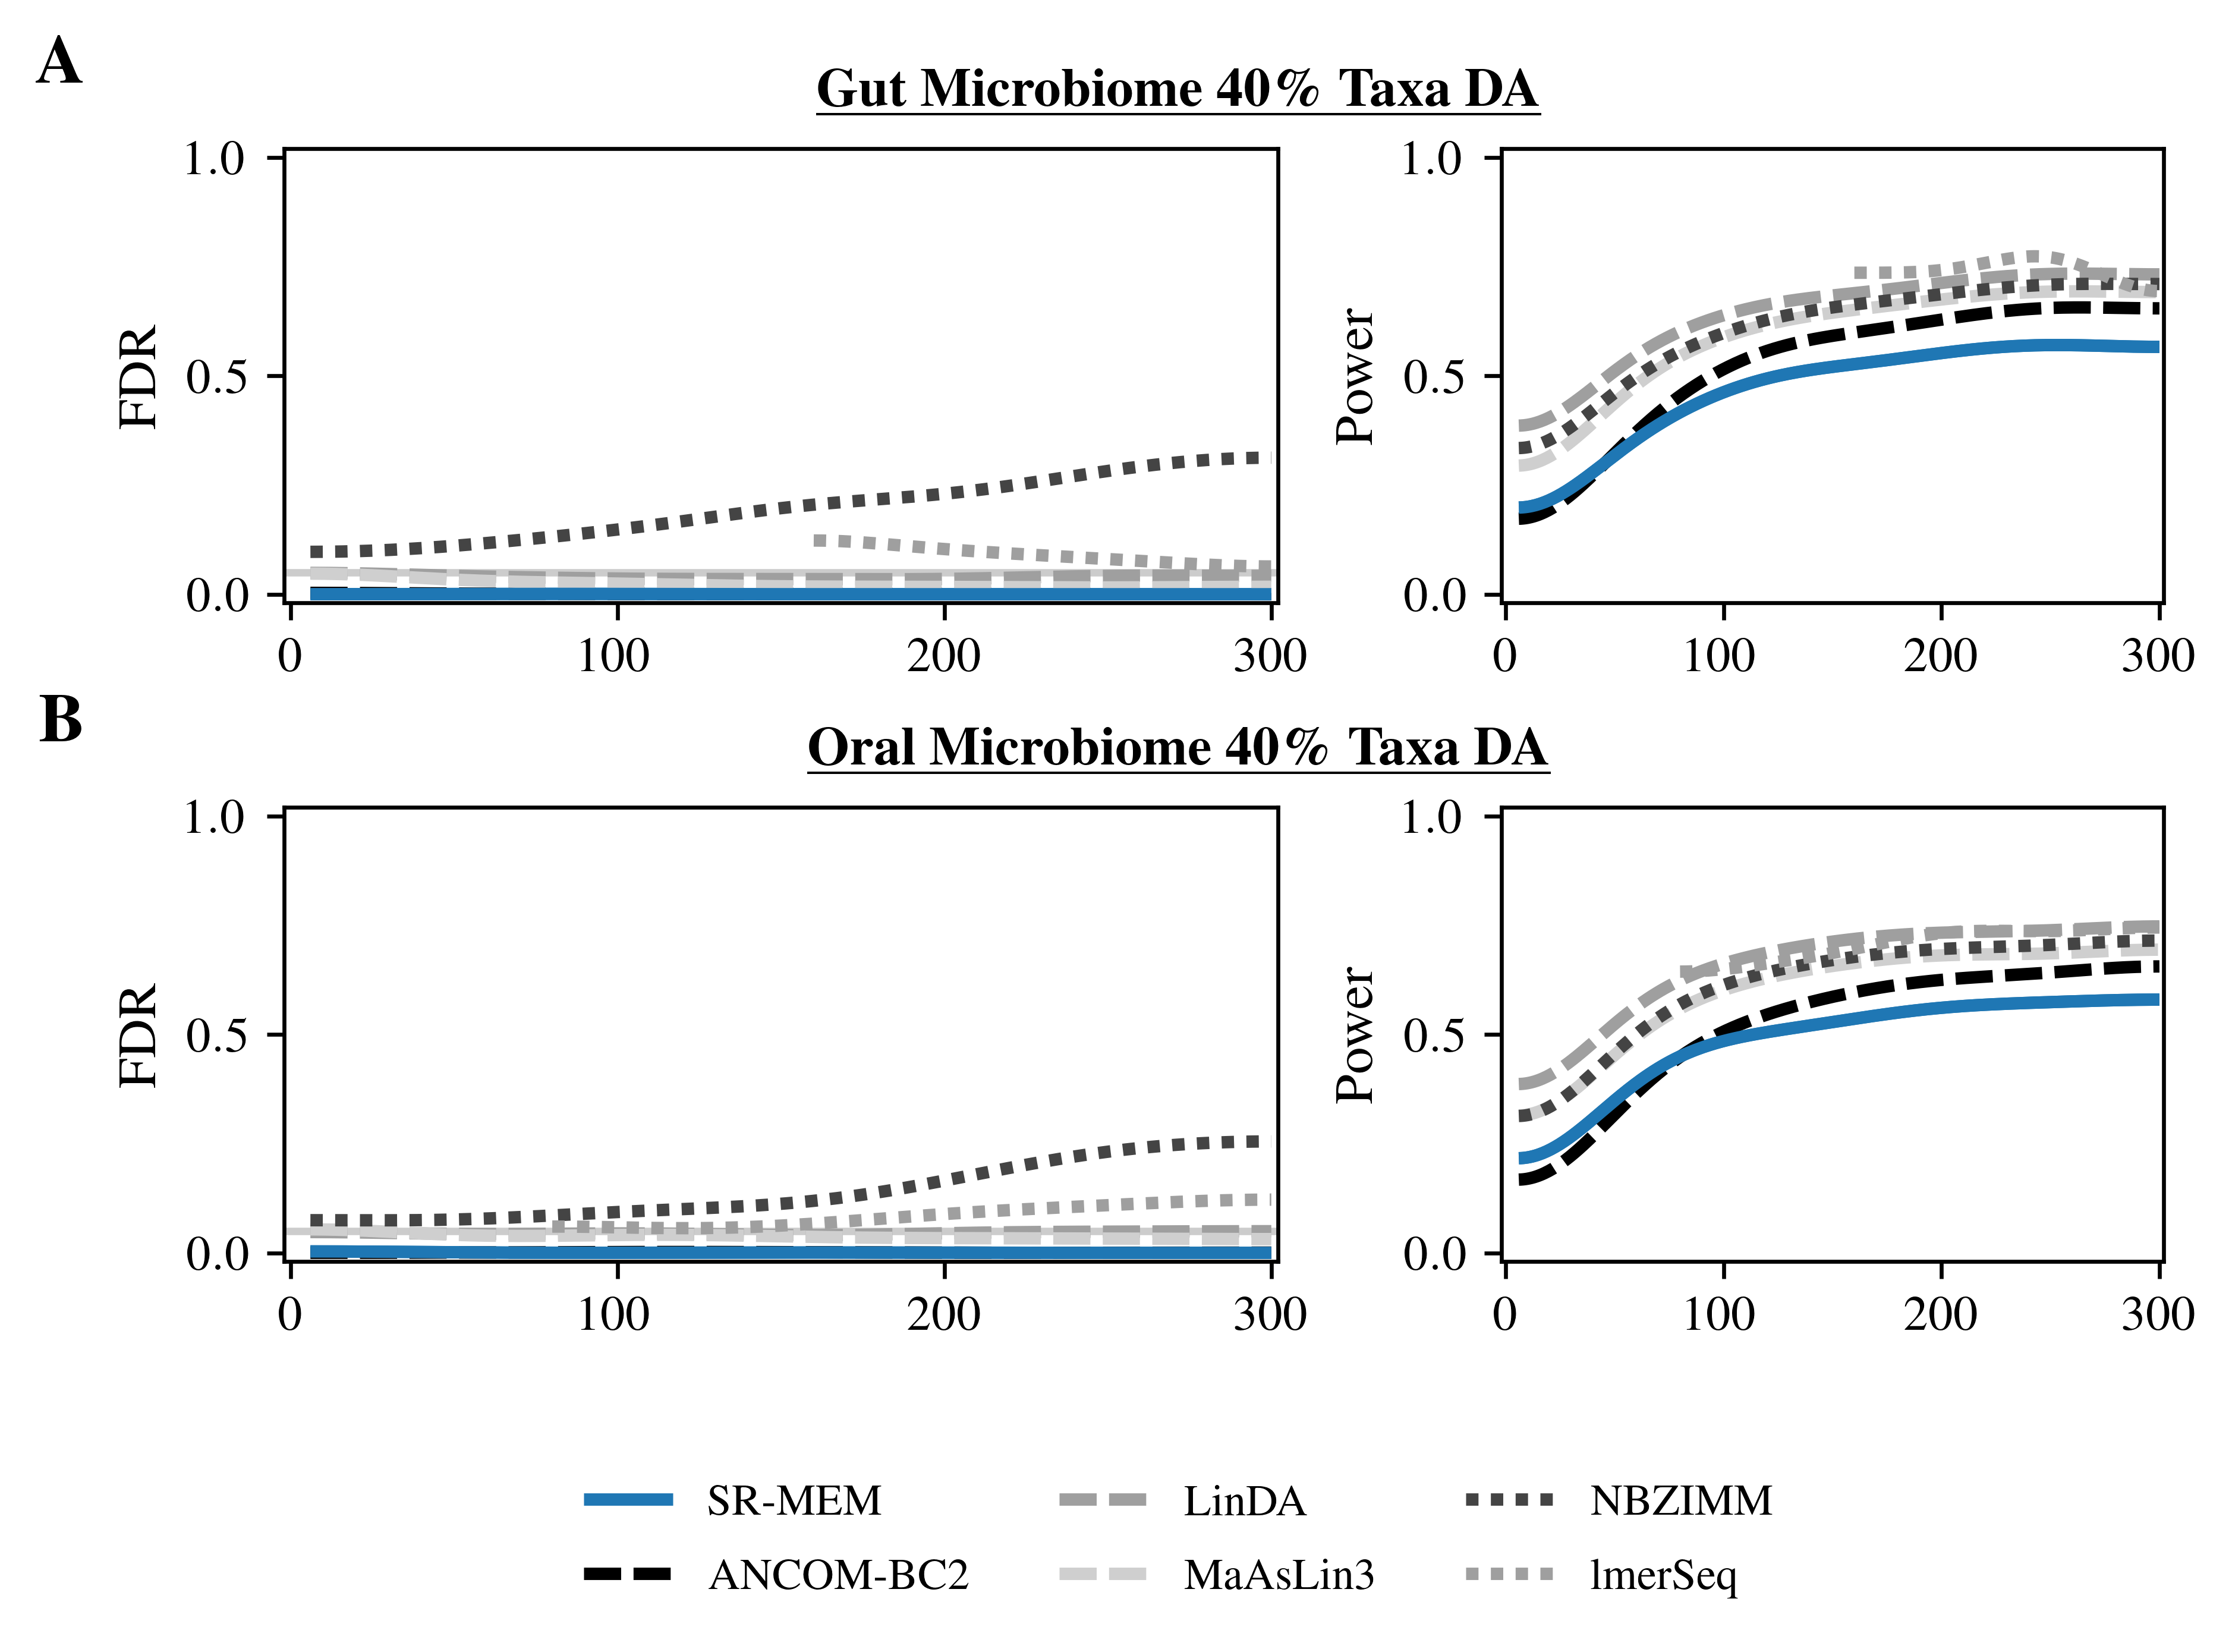

In [5]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["text.usetex"] = True

gs_kw = dict(width_ratios=[1.5,1],
             height_ratios=[1,1])

width = 6.8
height = 4
dpi = 600
pw = width*dpi
ph = height*dpi
palette = ['#1f77b4', '#000000', '#9F9F9F', '#CFCFCF', '#444444',  '#9F9F9F']
dashes = [(1,0), (3,1), (3,1), (3,1), (1,1), (1,1)]

fig, axs = plt.subplot_mosaic([["A", "B"],
                               ["C", "D"]], figsize=(pw/dpi, ph/dpi),
                              dpi=dpi, gridspec_kw=gs_kw)

def smooth_it(df_s, col, sigma=30):
    pdf = pd.DataFrame()
    for method in df_s["method"].unique():
        sdf = df_s[df_s["method"]==method]
        n_s = np.linspace(sdf["n_s"].min(), sdf["n_s"].max(), 300) 
        spl = make_interp_spline(sdf["n_s"], sdf[col], k=1)
        smoothed = gaussian_filter1d(spl(n_s), sigma=sigma)
        if col == "FDR_mean":
            name = "FDR_mean"
        else:
            name = "Power_mean"
        if pdf.empty:
            pdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
        else:
            tdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
            pdf = pd.concat([pdf, tdf])
    return(pdf)

ylim_l = -0.02
ylim_u = 1.02

counter = 0
axis_list = ["A", "B", "C", "D"]
sets = [["gut", 0.2, 0.2],
        ["oral", 0.2, 0.2]]
titles = ["Gut Microbiome 40\\% Taxa DA",
          "Oral Microbiome 40\\% Taxa DA"]
for index, curr_set in enumerate(sets):
    g_df = data_df.loc[
        (data_df["system"]==curr_set[0])&(data_df["pc_l"]==curr_set[1])&(data_df["pc_u"]==curr_set[2])]
    g_df = g_df.sort_values(by=["method", "n_s"])
    
    ax_l = axis_list[counter]
    ax_r = axis_list[counter+1]

    pdf = smooth_it(g_df, "FDR_mean")
    axs[ax_l].set_xlim(-2, 302)
    axs[ax_l].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="FDR_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    if curr_set!=["oral", 0.1, 0.41]:
        sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
                     style="method", palette=palette, ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    axs[ax_l].axhline(y=0.05, linestyle="solid", linewidth=1.5, color="gray", zorder=-5, alpha=0.4)
    axs[ax_l].get_legend().remove()
    if index==2:
        axs[ax_l].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_l].set_xlabel(None)
    axs[ax_l].set_ylabel("FDR", fontsize=11)
    axs[ax_l].text(0.9, 1.07, r"\underline{{\textbf{{{}}}}}".format(titles[index]), 
                   fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    #axs[ax_l].text(0.9, 1.07, r"\underline{\textbf{}}".format(titles[index]), 
    #               fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    
    pdf = smooth_it(g_df, "Power_mean")
    axs[ax_r].set_xlim(-2, 302)
    axs[ax_r].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="Power_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
                 style="method", palette=palette, ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    axs[ax_r].get_legend().remove()
    if index==2:
        axs[ax_r].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_r].set_xlabel(None)
    axs[ax_r].set_ylabel("Power", fontsize=11)
    
    counter += 2

axs["A"].text(-0.2, 1.25, r"\textbf{A}", transform=axs["A"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')
axs["C"].text(-0.2, 1.25, r"\textbf{B}", transform=axs["C"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(bottom=0.1, wspace=0.27, hspace=0.45)
handles, labels = axs["C"].get_legend_handles_labels()
label_dict = {"aldex": "SR-MEM", "ancombc2": "ANCOM-BC2",
              "linda": "LinDA", "lmerseq": "lmerSeq", "maaslin3": "MaAsLin3",
              "NBZIMM": "NBZIMM"}
labels = [label_dict[l] for l in labels]
leg = axs["C"].legend(handles=handles[0:6], labels=labels[0:6], ncol=3, loc='upper center', 
                      bbox_to_anchor=(0.9, -0.4), fancybox=False, shadow=False,
                      fontsize=9, frameon=False, labelspacing=0.75)
fig.savefig('../../../supplement/SFigure_3.png', bbox_inches='tight')

In [6]:
data_df = pd.read_csv("../results/simulation_results.2.csv", index_col=0)
data_df["method"] = pd.Categorical(data_df['method'], ["aldex", "ancombc2", "linda",
                                                       "lmerseq", "NBZIMM", "maaslin2", "aldex_lin"])
data_df = data_df[data_df["method"].isin(["aldex", "aldex_lin"])]

/tmp/ipykernel_186763/2040982460.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/2040982460.py:63: UserWarning: The dashes list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
/tmp/ipykernel_186763/2040982460.py:83: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/2040982460.py:83: UserWarning: The dashes list has more values (2) than needed (1), which may not be intended.
  sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
/tmp/ipykernel_186763/2040982460.py:63: UserWarning: The palette list has more values (2) than needed (1), which may n

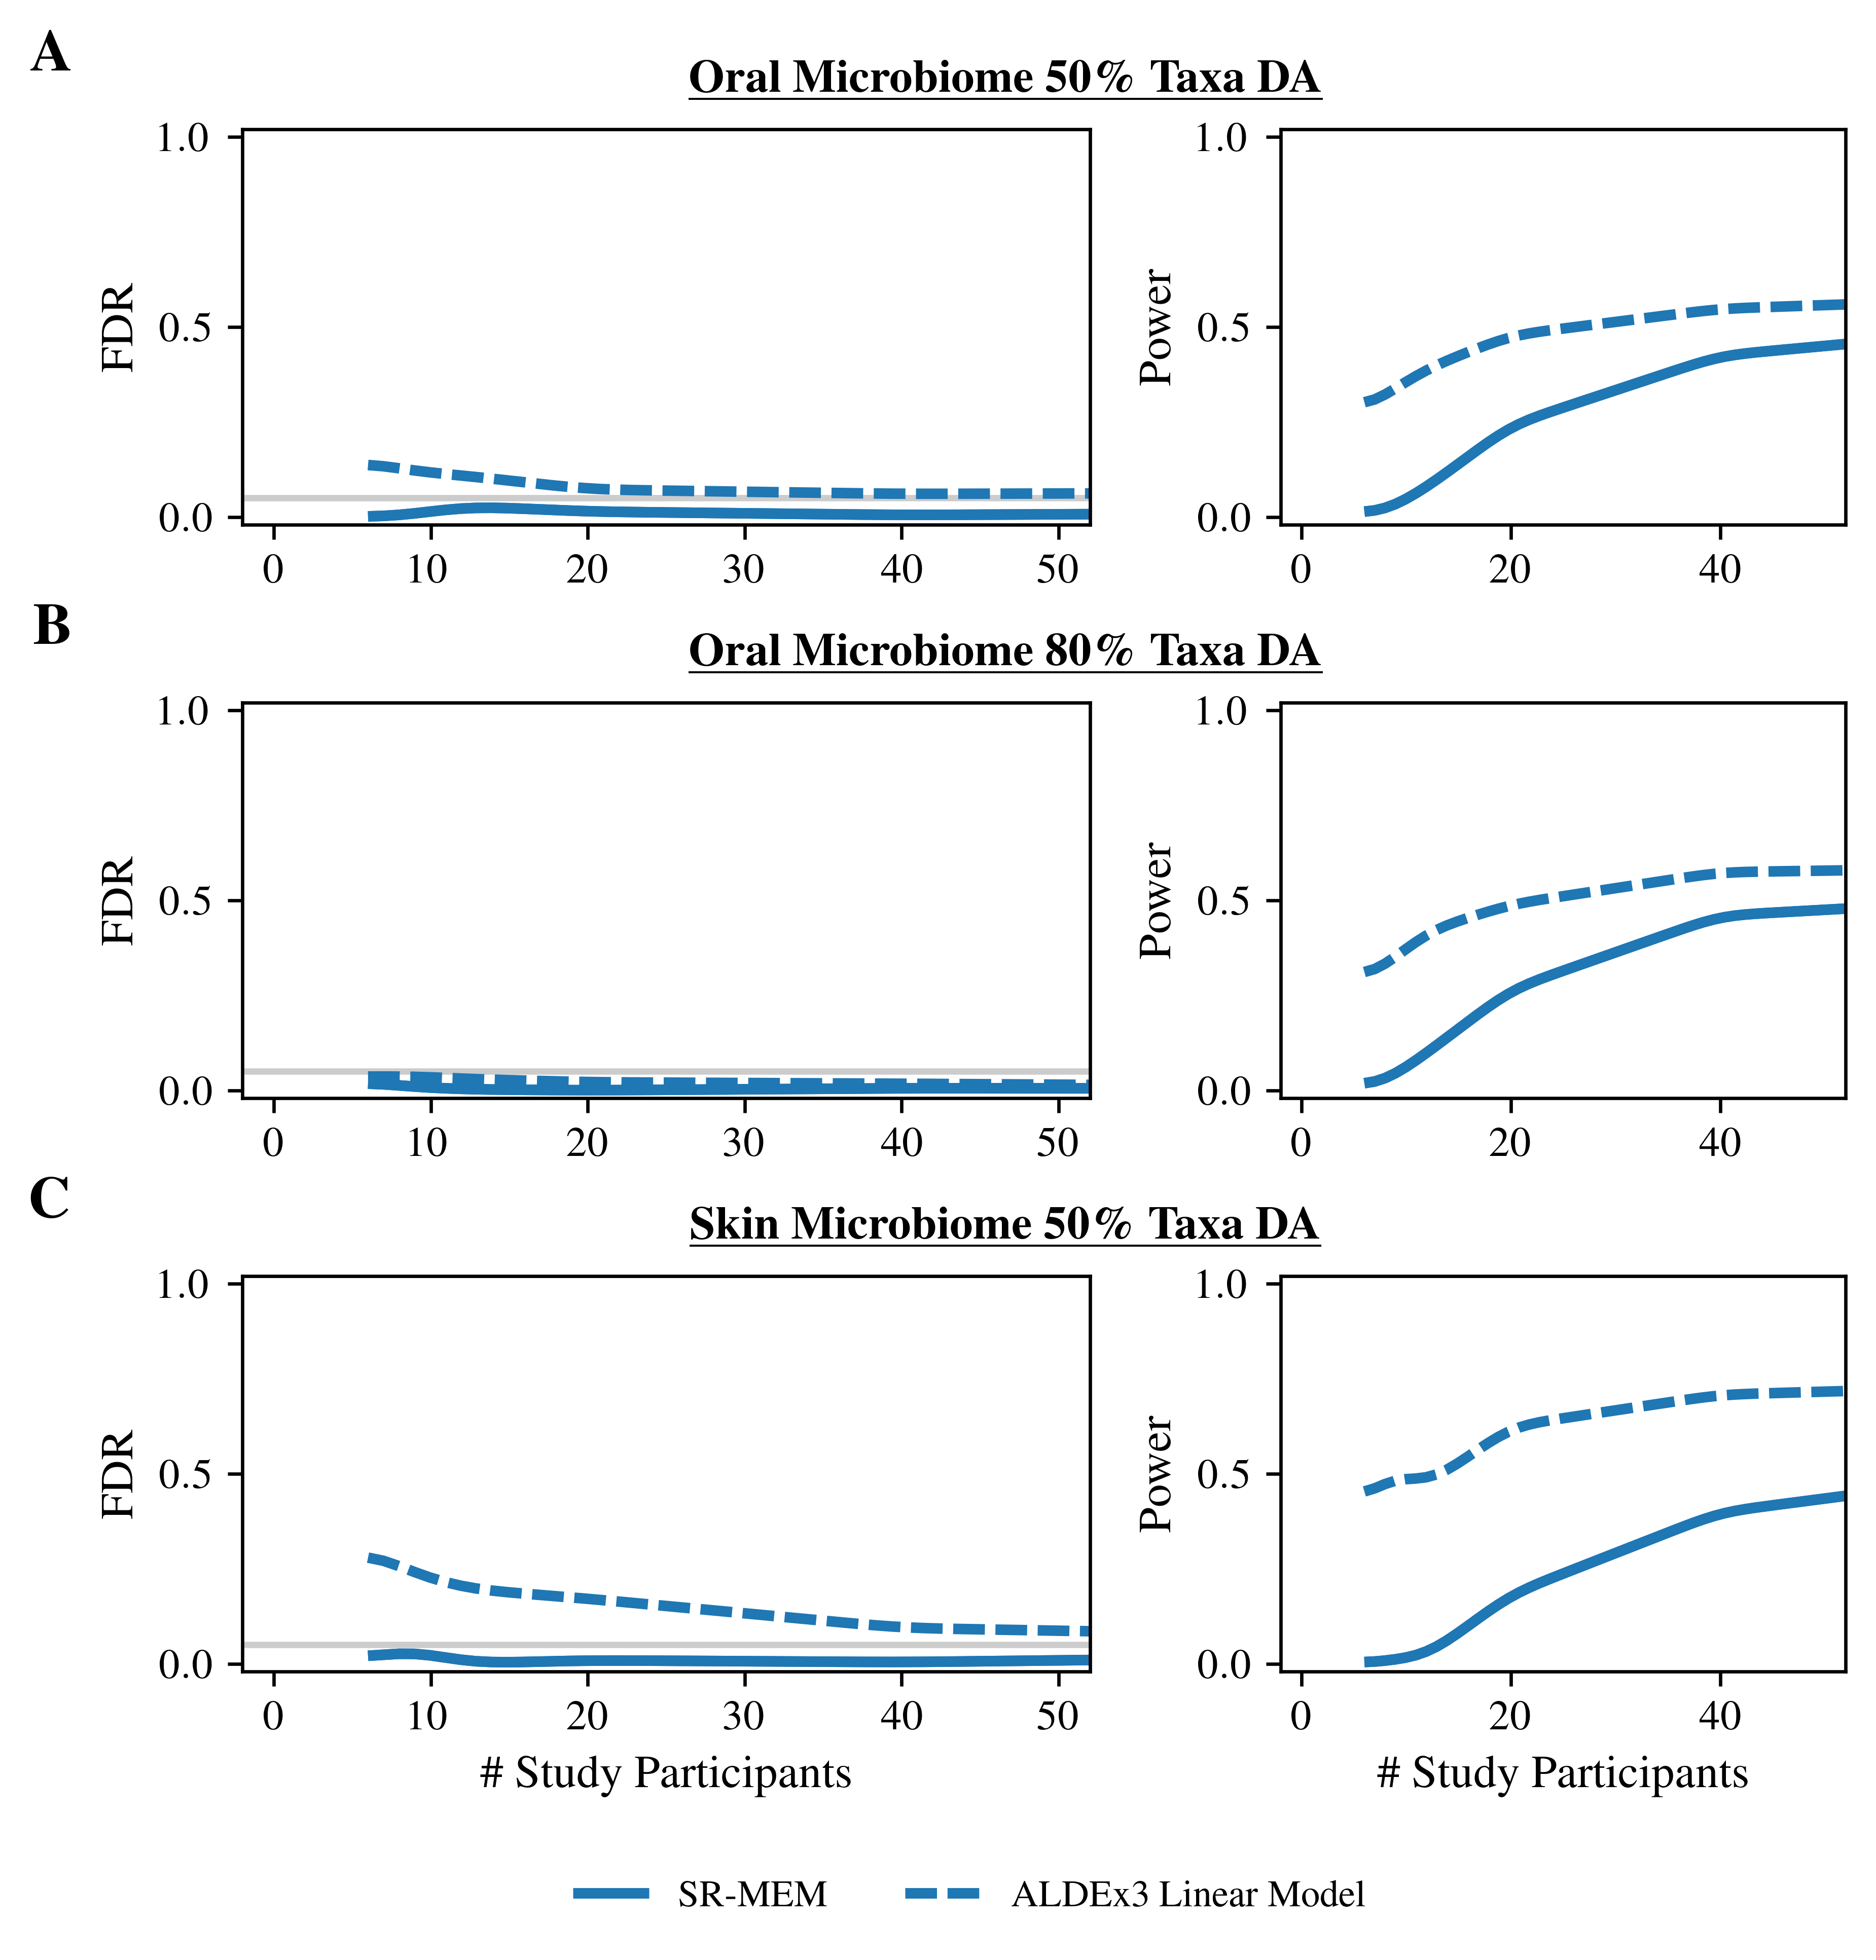

In [7]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["text.usetex"] = True

gs_kw = dict(width_ratios=[1.5,1],
             height_ratios=[1,1,1])

width = 6.8
height = 6.5
dpi = 600
pw = width*dpi
ph = height*dpi
palette = ['#1f77b4', '#1f77b4']
dashes = [(1,0), (3,1)]

fig, axs = plt.subplot_mosaic([["A", "B"],
                               ["C", "D"],
                               ["E", "F"]], figsize=(pw/dpi, ph/dpi),
                              dpi=dpi, gridspec_kw=gs_kw)

def smooth_it(df_s, col, sigma=2):
    pdf = pd.DataFrame()
    for method in df_s["method"].unique():
        sdf = df_s[df_s["method"]==method]
        n_s = np.linspace(sdf["n_s"].min(), sdf["n_s"].max(), 300) 
        spl = make_interp_spline(sdf["n_s"], sdf[col], k=1)
        smoothed = gaussian_filter1d(spl(n_s), sigma=sigma)
        if col == "FDR_mean":
            name = "FDR_mean"
        else:
            name = "Power_mean"
        if pdf.empty:
            pdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
        else:
            tdf = pd.DataFrame({"n_s": n_s, name: smoothed, "method": method})
            pdf = pd.concat([pdf, tdf])
    return(pdf)

ylim_l = -0.02
ylim_u = 1.02

counter = 0
axis_list = ["A", "B", "C", "D", "E", "F"]
sets = [["oral", 0.1, 0.4],
        ["oral", 0.1, 0.7],
        ["armpit", 0.0, 0.5]]
titles = ["Oral Microbiome 50\\% Taxa DA",
          "Oral Microbiome 80\\% Taxa DA",
          "Skin Microbiome 50\\% Taxa DA"]
for index, curr_set in enumerate(sets):
    g_df = data_df.loc[
        (data_df["system"]==curr_set[0])&(data_df["pc_l"]==curr_set[1])&(data_df["pc_u"]==curr_set[2])]
    g_df = g_df.sort_values(by=["method", "n_s"])
    
    ax_l = axis_list[counter]
    ax_r = axis_list[counter+1]

    pdf = smooth_it(g_df, "FDR_mean")
    axs[ax_l].set_xlim(-2, 52)
    axs[ax_l].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="FDR_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_l], linewidth=2.5, dashes=dashes)
    if curr_set!=["oral", 0.1, 0.41]:
        sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="FDR_mean", hue="method",
                     style="method", palette=palette, ax=axs[ax_l], linewidth=2.5, dashes=dashes,
                    legend=False)
    axs[ax_l].axhline(y=0.05, linestyle="solid", linewidth=1.5, color="gray", zorder=-5, alpha=0.4)
    axs[ax_l].get_legend().remove()
    if index==2:
        axs[ax_l].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_l].set_xlabel(None)
    axs[ax_l].set_ylabel("FDR", fontsize=11)
    axs[ax_l].text(0.9, 1.07, r"\underline{{\textbf{{{}}}}}".format(titles[index]), 
                   fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    #axs[ax_l].text(0.9, 1.07, r"\underline{\textbf{}}".format(titles[index]), 
    #               fontsize=11, ha='center', va='bottom', transform=axs[ax_l].transAxes)
    
    pdf = smooth_it(g_df, "Power_mean")
    axs[ax_r].set_xlim(-2, 52)
    axs[ax_r].set_ylim(ylim_l, ylim_u)
    sns.lineplot(data=pdf, x="n_s", y="Power_mean", hue="method", style="method", palette=palette,
                 ax=axs[ax_r], linewidth=2.5, dashes=dashes)
    sns.lineplot(data=pdf[pdf["method"]=="aldex"], x="n_s", y="Power_mean", hue="method",
                 style="method", palette=palette, ax=axs[ax_r], linewidth=2.5, dashes=dashes, legend=False)
    axs[ax_r].get_legend().remove()
    if index==2:
        axs[ax_r].set_xlabel("\# Study Participants", fontsize=11)
    else:
        axs[ax_r].set_xlabel(None)
    axs[ax_r].set_ylabel("Power", fontsize=11)
    
    counter += 2

axs["A"].text(-0.2, 1.25, r"\textbf{A}", transform=axs["A"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')
axs["C"].text(-0.2, 1.25, r"\textbf{B}", transform=axs["C"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')
axs["E"].text(-0.2, 1.25, r"\textbf{C}", transform=axs["E"].transAxes,
                fontsize=14, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(bottom=0.1, wspace=0.27, hspace=0.45)
handles, labels = axs["F"].get_legend_handles_labels()
label_dict = {"aldex": "SR-MEM", "aldex_lin": "ALDEx3 Linear Model"}
labels = [label_dict[l] for l in labels]
leg = axs["F"].legend(handles=handles[0:6], labels=labels[0:6], ncol=3, loc='upper center', 
                      bbox_to_anchor=(-0.55, -0.44), fancybox=False, shadow=False,
                      fontsize=9, frameon=False, labelspacing=0.75)
fig.savefig('../../../supplement/SFigure_1.png', bbox_inches='tight')